In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

2.0.0-beta1


/Users/alket/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorboar

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [42]:
import pandas as pd
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
my_time_step = []
my_temps = []

gbc = data.groupby(by = data['cell_num'])
cell_2 = gbc.get_group('498-1268')
cell_2 = cell_2.iloc[::4, :]
my_step=0
for index, row in cell_2.iterrows():
    val_i = row['nr_people']
    my_temps.append(val_i)
    my_time_step.append(my_step)
    my_step = my_step + 1

my_series = np.array(my_temps)
print(len(my_series))
my_time = np.array(my_time_step)
print(len(my_time))

/Users/alket/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2952
2952


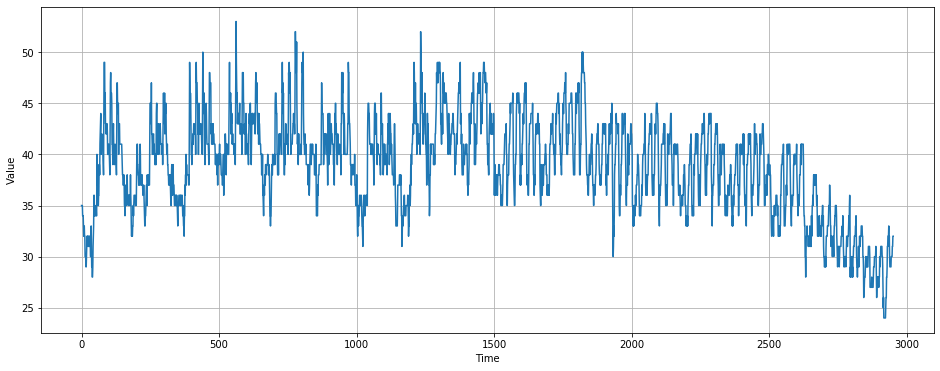

In [85]:
plt.figure(figsize=(16, 6))
plot_series(my_time[:4000], my_series[:4000])

In [86]:
split_time = 800
time_train = my_time[:split_time]
x_train = my_series[:split_time]
time_valid = my_time[split_time:]
x_valid = my_series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 100


In [87]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [88]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [89]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
#print(x_train.shape)

print()


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>



In [90]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(6),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=90, callbacks=[lr_schedule])

Epoch 1/90
3/3 [==============================] - 4s 1s/step - loss: 56.0981 - mae: 56.6022
Epoch 2/90
3/3 [==============================] - 1s 266ms/step - loss: 55.9329 - mae: 56.4369
Epoch 3/90
3/3 [==============================] - 1s 261ms/step - loss: 55.6327 - mae: 56.1376
Epoch 4/90
3/3 [==============================] - 1s 266ms/step - loss: 55.2308 - mae: 55.7362
Epoch 5/90
3/3 [==============================] - 1s 277ms/step - loss: 54.7539 - mae: 55.2593
Epoch 6/90
3/3 [==============================] - 1s 263ms/step - loss: 54.2244 - mae: 54.7295
Epoch 7/90
3/3 [==============================] - 1s 265ms/step - loss: 53.6599 - mae: 54.1649
Epoch 8/90
3/3 [==============================] - 1s 268ms/step - loss: 53.0718 - mae: 53.5768
Epoch 9/90
3/3 [==============================] - 1s 276ms/step - loss: 52.4656 - mae: 52.9704
Epoch 10/90
3/3 [==============================] - 1s 270ms/step - loss: 51.8431 - mae: 52.3479
Epoch 11/90
3/3 [==============================] - 1

3/3 [==============================] - 1s 273ms/step - loss: 8.1108 - mae: 8.6222
Epoch 88/90
3/3 [==============================] - 1s 275ms/step - loss: 6.2610 - mae: 6.7638
Epoch 89/90
3/3 [==============================] - 1s 270ms/step - loss: 8.6505 - mae: 9.1531
Epoch 90/90
3/3 [==============================] - 1s 272ms/step - loss: 7.4925 - mae: 8.0412


[1e-08, 0.0001, 0, 60]

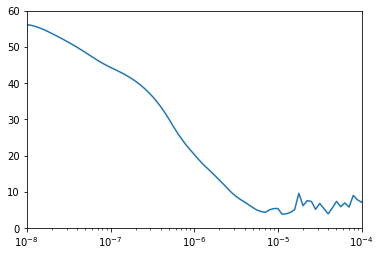

In [91]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=40)

Epoch 1/40
8/8 [==============================] - 4s 483ms/step - loss: 16.2856 - mae: 17.7590
Epoch 2/40
8/8 [==============================] - 1s 107ms/step - loss: 7.2091 - mae: 7.6995
Epoch 3/40
8/8 [==============================] - 1s 106ms/step - loss: 6.6453 - mae: 7.0231
Epoch 4/40
8/8 [==============================] - 1s 99ms/step - loss: 6.4323 - mae: 6.7826
Epoch 5/40
8/8 [==============================] - 1s 98ms/step - loss: 6.4419 - mae: 6.8700
Epoch 6/40
8/8 [==============================] - 1s 99ms/step - loss: 6.5611 - mae: 7.1238
Epoch 7/40
8/8 [==============================] - 1s 107ms/step - loss: 6.7430 - mae: 7.5289
Epoch 8/40
8/8 [==============================] - 1s 101ms/step - loss: 5.3955 - mae: 6.0370
Epoch 9/40
8/8 [==============================] - 1s 97ms/step - loss: 5.2107 - mae: 5.7904
Epoch 10/40
8/8 [==============================] - 1s 96ms/step - loss: 5.4609 - mae: 6.0879
Epoch 11/40
8/8 [==============================] - 1s 97ms/step - loss: 

In [93]:
rnn_forecast = model_forecast(model, my_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [94]:
print(rnn_forecast)

[45.583744 45.665478 45.94347  ... 39.04385  39.136955 39.289753]


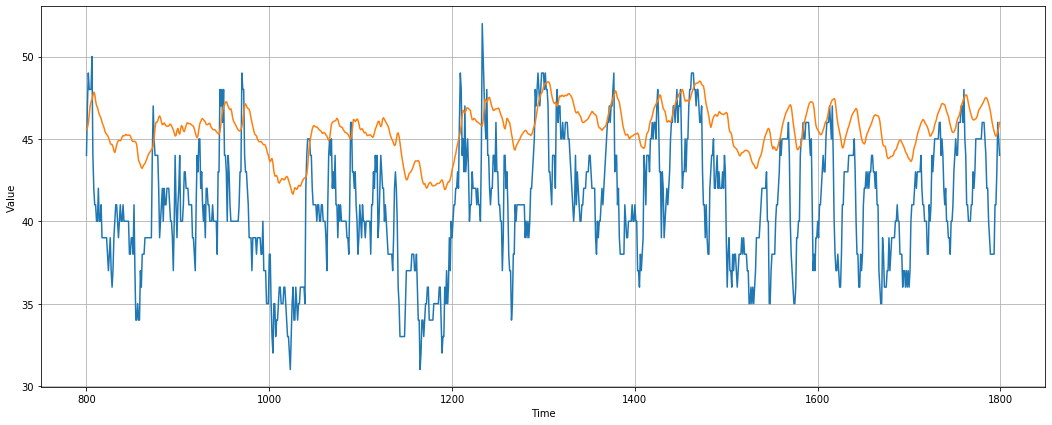

In [95]:
plt.figure(figsize=(18, 7))
plot_series(time_valid[:1000], x_valid[:1000])
plot_series(time_valid[:1000], rnn_forecast[:1000])

In [96]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.7642436

In [97]:
print(rnn_forecast)

[45.583744 45.665478 45.94347  ... 39.04385  39.136955 39.289753]


[1.58374405 1.33452225 3.05653    ... 8.04384995 7.13695526 7.28975296]


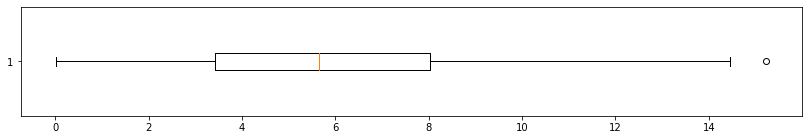

In [98]:
error = abs(x_valid - rnn_forecast)
print(error)
plt.figure(figsize = (14, 2))
plt.boxplot(error, vert = False)
plt.show()